In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import fast_evaluator, density_distance, ParallelNetworkOptimizer
import seaborn as sns
from dask_config import get_or_create_dask_client, DaskConfig

In [3]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/human/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

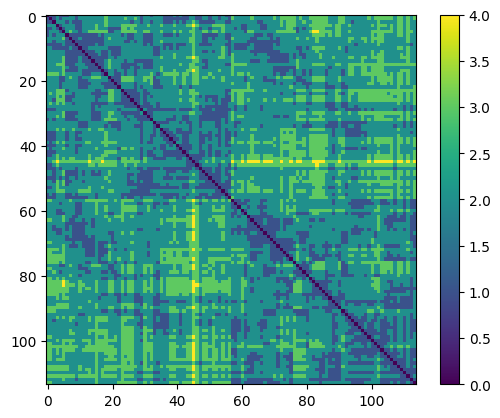

In [4]:
plt.imshow(gen.shortest_path_distance(connectivity, coordinates))
plt.colorbar()

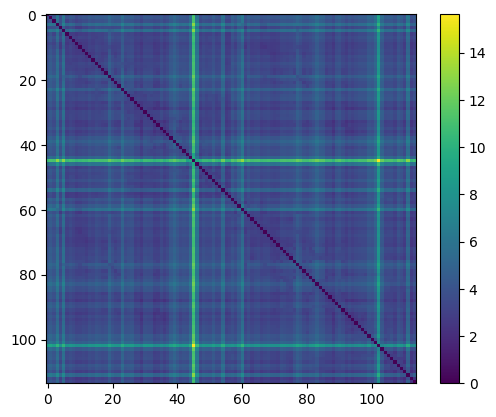

In [5]:
plt.imshow(gen.resistance_distance(connectivity, coordinates))
plt.colorbar()

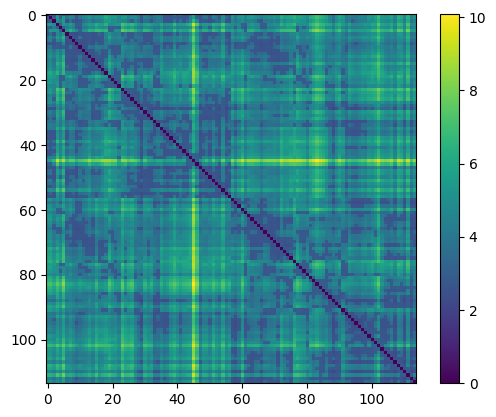

In [6]:
plt.imshow(gen.propagation_distance(connectivity, coordinates))
plt.colorbar()

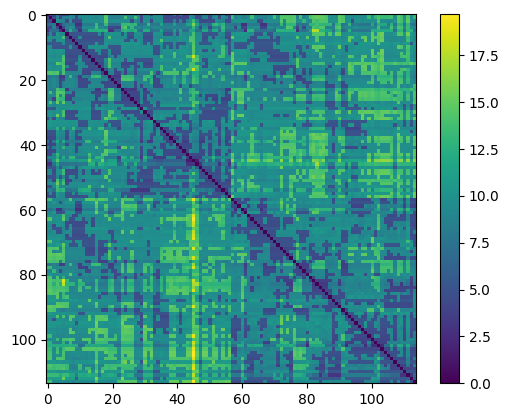

In [7]:
plt.imshow(gen.search_information(connectivity, coordinates))
plt.colorbar()

In [18]:
connectivity.shape[0]*0.05

5.7

In [19]:
# Configure parallel processing
config = DaskConfig(
    cluster_type='local',  # or 'slurm' for HPC
    n_workers=(8, 8),     # (simulation_cores, spo_cores)
    dashboard_port=8787,
)
client = get_or_create_dask_client(config)
print(client.dashboard_link)
# Create parameter trajectories
n_iterations = 500
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, 4.2)
beta = np.full(n_iterations, 0.1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
sampling_rate = np.full(n_iterations, 0.05)  # Can be scalar (0.1) or array
sampling_centers = None  # Optional: can be list of node indices

history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    distance_fn=gen.shortest_path_distance,
    alpha=alpha,
    beta=beta,
    noise=noise,
    connectivity_penalty=penalty,
    sampling_rate=sampling_rate,  # New parameter
    sampling_centers=sampling_centers,  # Optional
    sigma=1.0,  # Optional: controls spatial sampling spread
    dask_config=config
)

http://172.31.45.157:8787/status


Simulating network evolution: 100%|██████████| 499/499 [02:18<00:00,  3.59it/s]


In [ ]:
optimizer = ParallelNetworkOptimizer(
    simulation_model=gen.simulate_network_evolution,
    evaluation_function=density_distance,
    dask_config=config,
    param_bounds={
        'alpha': (0.01, 2),
        'beta': (0.01, 2)
    },
    sim_kwargs={
        'coordinates': coordinates,
        'n_iterations': 100,
        'distance_fn': gen.resistance_distance,
        'noise': np.zeros(100),
        'connectivity_penalty': np.zeros(100),
        'sampling_rate': 0.1,
    },
    eval_kwargs={
        'empirical': connectivity
    }
)

results = optimizer.optimize(n_particles=8, n_iterations=3)

In [20]:
np.sum(history[:,:,-1])/(connectivity.shape[0])**2

0.20298553401046476

In [21]:
np.sum(connectivity)/(connectivity.shape[0])**2

0.20098491843644198

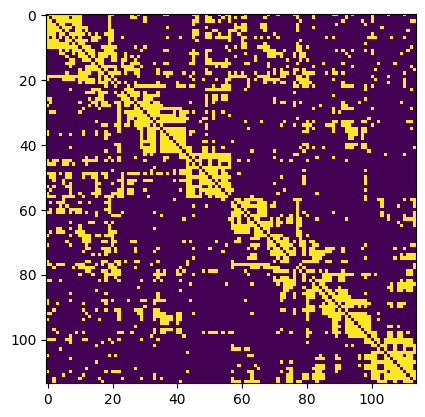

In [22]:
plt.imshow(history[:,:,-1])

In [23]:
# Vectorized correlation computation
flattened_history = history.reshape(history.shape[0] * history.shape[1], history.shape[2])
corr_matrix = np.corrcoef(flattened_history.T)


<Axes: >

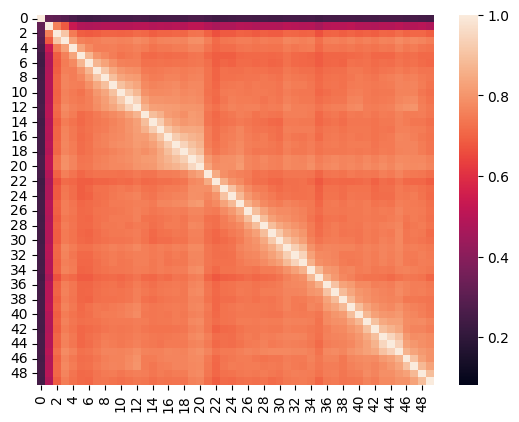

In [24]:
sns.heatmap(corr_matrix[::10,::10],vmin=corr_matrix.min(),vmax=1)

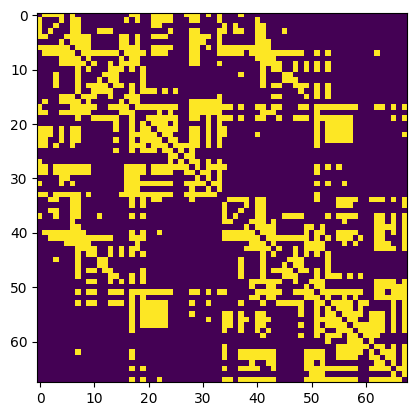

In [25]:
plt.imshow(connectivity)

In [25]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 500/500 [00:05<00:00, 88.38it/s]


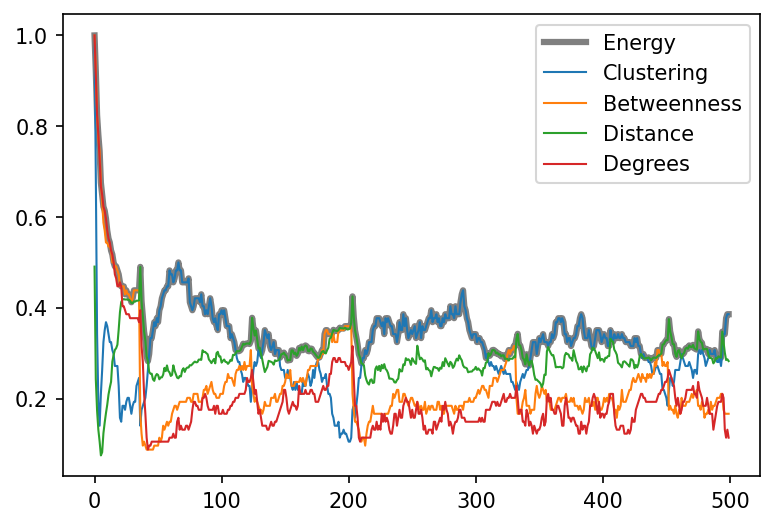

In [26]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [33]:
np.min(energy_vector)

0.38235294117647056

In [34]:
np.argmin(energy_vector)

107

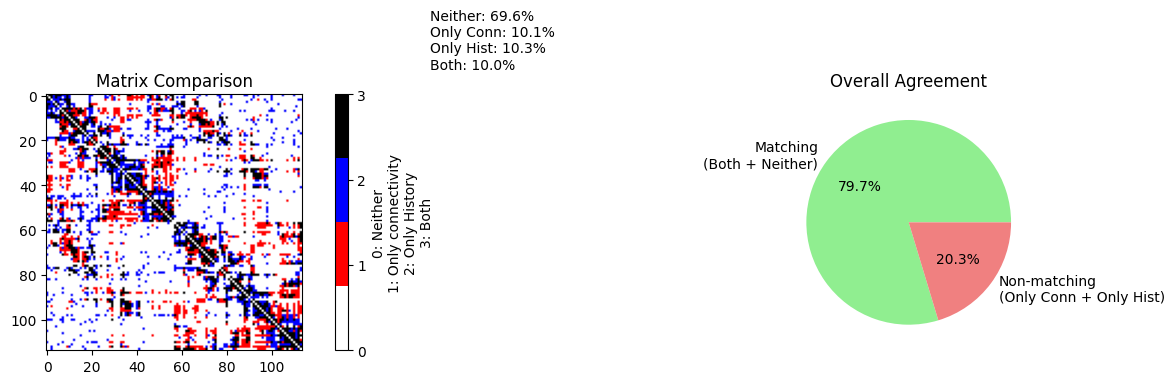

In [27]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = n_iterations-1

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only connectivity (red)
# 2: only history (blue)
# 3: both (black)
comparison = connectivity.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only connectivity\n2: Only History\n3: Both')

# Add percentage text
total = connectivity.shape[0] * connectivity.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution: 100%|██████████| 500/500 [00:00<00:00, 856.00it/s]


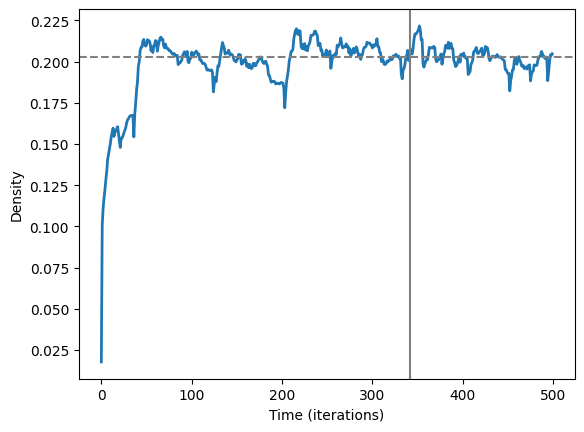

In [28]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')


In [29]:
import seaborn as sns

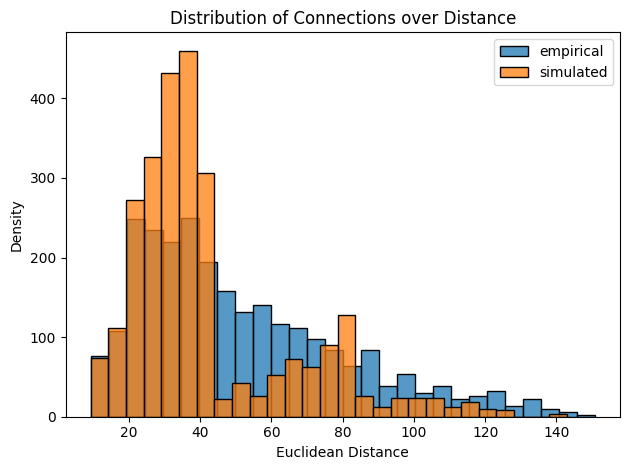

In [30]:
sns.histplot(euclidean_dis[connectivity],binwidth=5,label='empirical')
what = history[:,:,-1].astype(bool)
sns.histplot(euclidean_dis[what],binwidth=5,label='simulated')

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()